# COVID-19 Literature Clustering Task 3
Create a dataset that contains only the selected papers by all the course participants.
Perform the same clustering algorithm and analyse the resulting clusters.
Optional: create a Word-Cloud for each cluster. 

## Source
This notebook is abstracted from this original notebook: [COVID-19 Literature Clustering](https://www.kaggle.com/maksimeren/covid-19-literature-clustering/)

# Loading the Data
Load the data following the notebook by Ivan Ega Pratama, from Kaggle.
#### Cite: [Dataset Parsing Code | Kaggle, COVID EDA: Initial Exploration Tool](https://www.kaggle.com/ivanegapratama/covid-eda-initial-exploration-tool)

### Loading Metadata

In [4]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import glob
import json

import matplotlib.pyplot as plt
plt.style.use('ggplot')

Let's load the metadata of the dateset. 'title' and 'journal' attributes may be useful later when we cluster the articles to see what kinds of articles cluster together.

In [414]:
# SET THE PATH TO THE CORD-19 DATA DIRECTORY
root_path = 'D:\\DSinLS_Data\\'
# SET THE DIRECTORY FOR BOKEH DOWNLOADS
lib_path = 'D:\\DSinLS_Data\\'
# SET THE PATH TO THE STUDENT PICKED DATAFRAME
student_df_path = "D:\\DSinLS_Data\\DSinLS - SS2020 - List.csv"

In [413]:
# load meta data
metadata_path = f'{root_path}metadata.csv'
meta_df = pd.read_csv(metadata_path, dtype={
    'pubmed_id': str,
    'Microsoft Academic Paper ID': str, 
    'doi': str
})
meta_df.head()

D:\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,cord_uid,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,journal,Microsoft Academic Paper ID,WHO #Covidence,arxiv_id,has_pdf_parse,has_pmc_xml_parse,full_text_file,url
0,zjufx4fo,b2897e1277f56641193a6db73825f707eed3e4c9,PMC,Sequence requirements for RNA strand transfer ...,10.1093/emboj/20.24.7220,PMC125340,11742998,unk,Nidovirus subgenomic mRNAs contain a leader se...,2001-12-17,"Pasternak, Alexander O.; van den Born, Erwin; ...",The EMBO Journal,NaN,NaN,NaN,True,True,custom_license,http://europepmc.org/articles/pmc125340?pdf=re...
1,ymceytj3,e3d0d482ebd9a8ba81c254cc433f314142e72174,PMC,"Crystal structure of murine sCEACAM1a[1,4]: a ...",10.1093/emboj/21.9.2076,PMC125375,11980704,unk,CEACAM1 is a member of the carcinoembryonic an...,2002-05-01,"Tan, Kemin; Zelus, Bruce D.; Meijers, Rob; Liu...",The EMBO Journal,NaN,NaN,NaN,True,True,custom_license,http://europepmc.org/articles/pmc125375?pdf=re...
2,wzj2glte,00b1d99e70f779eb4ede50059db469c65e8c1469,PMC,Synthesis of a novel hepatitis C virus protein...,10.1093/emboj/20.14.3840,PMC125543,11447125,no-cc,Hepatitis C virus (HCV) is an important human ...,2001-07-16,"Xu, Zhenming; Choi, Jinah; Yen, T.S.Benedict; ...",EMBO J,NaN,NaN,NaN,True,True,custom_license,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1...
3,2sfqsfm1,cf584e00f637cbd8f1bb35f3f09f5ed07b71aeb0,PMC,Structure of coronavirus main proteinase revea...,10.1093/emboj/cdf327,PMC126080,12093723,unk,The key enzyme in coronavirus polyprotein proc...,2002-07-01,"Anand, Kanchan; Palm, Gottfried J.; Mesters, J...",The EMBO Journal,NaN,NaN,NaN,True,True,custom_license,http://europepmc.org/articles/pmc126080?pdf=re...
4,i0zym7iq,dde02f11923815e6a16a31dd6298c46b109c5dfa,PMC,Discontinuous and non-discontinuous subgenomic...,10.1093/emboj/cdf635,PMC136939,12456663,unk,"Arteri-, corona-, toro- and roniviruses are ev...",2002-12-01,"van Vliet, A.L.W.; Smits, S.L.; Rottier, P.J.M...",The EMBO Journal,NaN,NaN,NaN,True,True,custom_license,http://europepmc.org/articles/pmc136939?pdf=re...


In [22]:
meta_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59887 entries, 0 to 59886
Data columns (total 19 columns):
cord_uid                       59887 non-null object
sha                            45763 non-null object
source_x                       59887 non-null object
title                          59724 non-null object
doi                            55801 non-null object
pmcid                          48139 non-null object
pubmed_id                      41328 non-null object
license                        59887 non-null object
abstract                       48757 non-null object
publish_time                   59879 non-null object
authors                        57296 non-null object
journal                        52828 non-null object
Microsoft Academic Paper ID    964 non-null object
WHO #Covidence                 1768 non-null object
arxiv_id                       676 non-null object
has_pdf_parse                  59887 non-null bool
has_pmc_xml_parse              59887 non-null bool

### Fetch All of JSON File Path

Get path to all JSON files:

In [23]:
all_json = glob.glob(f'{root_path}/**/*.json', recursive=True)
len(all_json)

71261

### Helper Functions

 File Reader Class

In [24]:
class FileReader:
    def __init__(self, file_path):
        with open(file_path) as file:
            content = json.load(file)
            self.paper_id = content['paper_id']
            self.abstract = []
            self.body_text = []
            # Abstract
            for entry in content['abstract']:
                self.abstract.append(entry['text'])
            # Body text
            for entry in content['body_text']:
                self.body_text.append(entry['text'])
            self.abstract = '\n'.join(self.abstract)
            self.body_text = '\n'.join(self.body_text)
    def __repr__(self):
        return f'{self.paper_id}: {self.abstract[:200]}... {self.body_text[:200]}...'
first_row = FileReader(all_json[0])
print(first_row)

003d2e515e1aaf06f0052769953e861ed8e56608: ... It is highly contagious, and severe cases can lead to acute respiratory distress or multiple organ failure [3] . On 11 March 2020, the WHO has made the assessment that COVID-19 can be characterised as...


Helper function adds break after every words when character length reach to certain amount. This is for the interactive plot so that hover tool fits the screen.

In [25]:
def get_breaks(content, length):
    data = ""
    words = content.split(' ')
    total_chars = 0

    # add break every length characters
    for i in range(len(words)):
        total_chars += len(words[i])
        if total_chars > length:
            data = data + "<br>" + words[i]
            total_chars = 0
        else:
            data = data + " " + words[i]
    return data

### Load the Data into DataFrame

Using the helper functions, let's read in the articles into a DataFrame that can be used easily:

In [26]:
dict_ = {'paper_id': [], 'doi':[], 'abstract': [], 'body_text': [], 'authors': [], 'title': [], 'journal': [], 'abstract_summary': []}
for idx, entry in enumerate(all_json):
    if idx % (len(all_json) // 10) == 0:
        print(f'Processing index: {idx} of {len(all_json)}')
    
    try:
        content = FileReader(entry)
    except Exception as e:
        continue  # invalid paper format, skip
    
    # get metadata information
    meta_data = meta_df.loc[meta_df['sha'] == content.paper_id]
    # no metadata, skip this paper
    if len(meta_data) == 0:
        continue
    
    dict_['abstract'].append(content.abstract)
    dict_['paper_id'].append(content.paper_id)
    dict_['body_text'].append(content.body_text)
    
    # also create a column for the summary of abstract to be used in a plot
    if len(content.abstract) == 0: 
        # no abstract provided
        dict_['abstract_summary'].append("Not provided.")
    elif len(content.abstract.split(' ')) > 100:
        # abstract provided is too long for plot, take first 100 words append with ...
        info = content.abstract.split(' ')[:100]
        summary = get_breaks(' '.join(info), 40)
        dict_['abstract_summary'].append(summary + "...")
    else:
        # abstract is short enough
        summary = get_breaks(content.abstract, 40)
        dict_['abstract_summary'].append(summary)
        
    # get metadata information
    meta_data = meta_df.loc[meta_df['sha'] == content.paper_id]
    
    try:
        # if more than one author
        authors = meta_data['authors'].values[0].split(';')
        if len(authors) > 2:
            # if more than 2 authors, take them all with html tag breaks in between
            dict_['authors'].append(get_breaks('. '.join(authors), 40))
        else:
            # authors will fit in plot
            dict_['authors'].append(". ".join(authors))
    except Exception as e:
        # if only one author - or Null valie
        dict_['authors'].append(meta_data['authors'].values[0])
    
    # add the title information, add breaks when needed
    try:
        title = get_breaks(meta_data['title'].values[0], 40)
        dict_['title'].append(title)
    # if title was not provided
    except Exception as e:
        dict_['title'].append(meta_data['title'].values[0])
    
    # add the journal information
    dict_['journal'].append(meta_data['journal'].values[0])
    
    # add doi
    dict_['doi'].append(meta_data['doi'].values[0])
    
df_covid = pd.DataFrame(dict_, columns=['paper_id', 'doi', 'abstract', 'body_text', 'authors', 'title', 'journal', 'abstract_summary'])
df_covid.head()

Processing index: 0 of 71261
Processing index: 7126 of 71261
Processing index: 14252 of 71261
Processing index: 21378 of 71261
Processing index: 28504 of 71261
Processing index: 35630 of 71261
Processing index: 42756 of 71261
Processing index: 49882 of 71261
Processing index: 57008 of 71261
Processing index: 64134 of 71261
Processing index: 71260 of 71261


,paper_id,doi,abstract,body_text,authors,title,journal,abstract_summary
0,003d2e515e1aaf06f0052769953e861ed8e56608,NaN,,"It is highly contagious, and severe cases can ...",Shaoping Hu. Yuan Gao. Zhangming Niu. Ying...,Weakly Supervised Deep Learning for COVID-19<...,NaN,Not provided.
1,00a407540a8bdd6d7425bd8a561eb21d69682511,NaN,Rapidly developed AI-based automated CT image ...,• For Coronavirus patients the system outputs ...,Ophir Gozes. Maayan Frid-Adar. Hayit<br>Gre...,Rapid AI Development Cycle for the Coronaviru...,NaN,Rapidly developed AI-based automated CT image...
2,00c386ee8b9fac7eeb2291a72d52966d83eec814,NaN,It is shown that the evaporation rate of a liq...,It is shown that the evaporation rate of a liq...,P. Grinchuk S.. E. Fisenko I.. S. Fisenko P...,Isothermal evaporation rate of deposited<br>l...,NaN,It is shown that the evaporation rate of a li...
3,024b30561568979f525d8b2580f85122c02008a0,NaN,A model of reactive social distancing in epide...,Let the proportions of a population who are su...,Rose Baker,Reactive Social distancing in a SIR model of<...,NaN,A model of reactive social distancing in<br>e...
4,02b3c0c87a6b32d5107a6e05f83f73cb7f939432,NaN,Large scale disease screening is a complicated...,In many cohort studies specimens collected fro...,Gregory Haber. Yaakov Malinovsky. Paul Albe...,Is Group Testing Ready for Prime-time in<br>D...,NaN,Large scale disease screening is a complicate...


## Filter the Dataframe

### Load in the Students selected Dataframe

In [415]:
studi_df = pd.read_csv(student_df_path, delimiter=";")
studi_df.head(10)

,LAST 4 DIGITS OF YOUR MATRIKEL NUMBER,LINK,TITLE
0,NaN,NaN,NaN
1,NaN,NaN,NaN
2,NaN,NaN,NaN
3,NaN,NaN,NaN
4,NaN,NaN,NaN
5,9477.0,http://doi.org/10.1007/978-981-10-5287-3_2,How Behaviour and the Environment Influence T...
6,9477.0,http://doi.org/10.1186/s12879-016-2003-3,Recalibrating disease parameters for increasin...
7,9477.0,http://doi.org/10.1186/1471-2334-11-199,Analysis of CDC social control measures using...
8,9477.0,http://doi.org/10.1097/phh.0b013e3181ce594e,Simulating School Closure Strategies to Mitig...
9,9477.0,http://doi.org/10.1007/s10588-008-9027-1,Pandemic simulation of antivirals + school cl...


### Check for duplicates and null entries

In [7]:
studi_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 217 entries, 0 to 216
Data columns (total 3 columns):
LAST 4 DIGITS OF YOUR MATRIKEL NUMBER    192 non-null float64
LINK                                     196 non-null object
TITLE                                    196 non-null object
dtypes: float64(1), object(2)
memory usage: 5.2+ KB


In [14]:
studi_df.dropna(inplace=True)
studi_df.drop("LAST 4 DIGITS OF YOUR MATRIKEL NUMBER", axis=1, inplace=True)
studi_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 191 entries, 5 to 210
Data columns (total 2 columns):
LINK     191 non-null object
TITLE    191 non-null object
dtypes: object(2)
memory usage: 4.5+ KB


In [18]:
studi_df['TITLE'].describe(include='all')

count                                                   191
unique                                                  180
top       Time-series modelling and forecasting of hand,...
freq                                                      3
Name: TITLE, dtype: object

In [12]:
studi_df['LINK'].describe(include='all')

count                                                   191
unique                                                  184
top       https://www.tandfonline.com/doi/full/10.1586/1...
freq                                                      2
Name: LINK, dtype: object

In [83]:
title_list = studi_df['TITLE'].drop_duplicates()
link_list = studi_df['LINK'].drop_duplicates()

In [34]:
title_list

5       How Behaviour and the Environment Influence T...
6      Recalibrating disease parameters for increasin...
7       Analysis of CDC social control measures using...
8       Simulating School Closure Strategies to Mitig...
9       Pandemic simulation of antivirals + school cl...
10     The utility of LASSO-based models for real tim...
11            Forecasting the novel coronavirus COVID-19
12     Preliminary Assessment of the COVID-19 Outbrea...
13     Modeling Control Strategies of Respiratory Pat...
14     Prediction of COVID-19 Outbreak in China and O...
15     Association between clinical manifestations an...
16     Clinical characteristics of 25 death cases wit...
17     Is low sodium intake a risk factor for severe ...
18     COVID-19 and cardiovascular disease: What we k...
19     Clinical Characteristics of COVID-19 Patients ...
20     RPiRLS: Quantitative Predictions of RNA Intera...
21     Ranking protein–protein docking results using ...
22     Transmembrane helices th

### Filter the original full dataframe

In [46]:
df_covid["title"] = df_covid["title"].replace('<br>',' ', regex=True)
df_covid.dropna(inplace=True)

In [231]:
# filter the whole dataframe by titles, while escaping all regex characters and putting the strings to lowercase
df_list = []
multi_title_found = []
no_title_found = []
for title in title_list:
    title2 = title.replace('(','\(').replace(')','\)').replace('?','\?').replace('+','\+')
    temp_df = df_covid[df_covid['title'].str.lower().str.contains(' '.join(title2.split()[0:9]).lower())]
    if len(temp_df) == 1:
        df_list.append(temp_df)
    elif len(temp_df) > 1:
        multi_title_found.append(title)
    else:
        no_title_found.append(title)
print("Unique Match: ",len(df_list), "Multi Matches: ",len(multi_title_found), "No Match: ", len(no_title_found))

Unique Match:  163 Multi Matches:  2 No Match:  15


In [232]:
# all the papers with multiple matches
multi_title_found

['3D QSAR Studies, Pharmacophore Modeling and Virtual Screening on a Series of Steroidal Aromatase Inhibitors',
 "Modeling and analysis of epidemic spreading on community network with node's birth and death"]

In [233]:
# add the multimatches with some additional regex constraints
multi_title_found_again = []
no_title_found_now = []
for title in multi_title_found:
    title2 = title.replace('(','\(').replace(')','\)').replace('?','\?').replace('+','\+')
    temp_df = df_covid[df_covid['title'].str.lower().str.contains('^ ' + ' '.join(title2.split()[0:10]).lower())]
    if len(temp_df) == 1:
        df_list.append(temp_df)
    elif len(temp_df) > 1:
        multi_title_found_again.append(title)
    else:
        no_title_found_now.append(title)
print("Unique Match: ",len(df_list), "Multi Matches: ",len(multi_title_found_again), "No Match: ", len(no_title_found_now))

Unique Match:  165 Multi Matches:  0 No Match:  0


In [234]:
# these papers could not be found, even after manually checking 
print("Number of Papers not found: ", len(no_title_found))
no_title_found

Number of Papers not found:  15


['Ranking protein–protein docking results using steered molecular dynamics and potential of mean force calculations',
 'Simulation Models for Transmission of Health Care-Associated Infection: A Systematic Review',
 'Forecasting the Worldwide Spread of COVID-19 based on Logistic Model and SEIR Model',
 ' Spatial approximations of network-based individual level infectious disease models',
 'Simulating and forecasting the cumulative confirmed cases of SARS-CoV-2 in china by Boltzmann function-based regression analyses',
 'Trend Analysis and Forecasting of COVID-19 outbreak in India',
 'COVID-19: Forecasting short term hospital needs in France',
 'Multiple-Input Deep Convolutional Neural Network Model for COVID-19 Forecasting in China',
 'Modeling COVID-19: Forecasting and analyzing the dynamics of the outbreak in Hubei and Turkey',
 'Epidemiology of Coronavirus COVID-19: Forecasting the Future Incidence in Different Countries',
 'Forecasting COVID-19 impact on hospital bed-days, ICU-days,

In [269]:
# concatenate all uniquely matched papers in a df
df_studi_filtered = pd.concat(df_list)
df_studi_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 165 entries, 36577 to 38665
Data columns (total 8 columns):
paper_id            165 non-null object
doi                 165 non-null object
abstract            165 non-null object
body_text           165 non-null object
authors             165 non-null object
title               165 non-null object
journal             165 non-null object
abstract_summary    165 non-null object
dtypes: object(8)
memory usage: 11.6+ KB


## Some feature engineering
Adding word count columns for both abstract and body_text can be useful parameters later:

In [270]:
df_studi_filtered['abstract_word_count'] = df_studi_filtered['abstract'].apply(lambda x: len(x.strip().split()))  # word count in abstract
df_studi_filtered['body_word_count'] = df_studi_filtered['body_text'].apply(lambda x: len(x.strip().split()))  # word count in body
df_studi_filtered['body_unique_words']=df_studi_filtered['body_text'].apply(lambda x:len(set(str(x).split())))  # number of unique words in body
df_studi_filtered.head()

,paper_id,doi,abstract,body_text,authors,title,journal,abstract_summary,abstract_word_count,body_word_count,body_unique_words
36577,d5cd67586cce346312cd5671aaae441227983075,10.1007/978-981-10-5287-3_2,The movement of individuals living in groups l...,the environment cannot physically support such...,"Gorochowski, Thomas E.. Richardson, Thomas O.",How Behaviour and the Environment Influence T...,Temporal Network Epidemiology,The movement of individuals living in groups<...,722,6778,1824
8092,82e33ea1413ab8560304175a8281348a156c2e47,10.1186/s12879-016-2003-3,Background: The homogeneous mixing assumption ...,spatial spread of the epidemic and of the effe...,"Bioglio, Livio. Génois, Mathieu. <br>Vesterg...",Recalibrating disease parameters for increasi...,BMC Infect Dis,Background: The homogeneous mixing<br>assumpt...,347,7290,1696
3663,06589343cb2fcc62a39c587071c8a9e76836f993,10.1186/1471-2334-11-199,Background: The transmission of infectious dis...,"Since the beginning of the new millennium, epi...","Yang, Yong. Atkinson, Peter M. Ettema, Dick",Analysis of CDC social control measures using...,BMC Infect Dis,Background: The transmission of infectious<br...,313,4482,1386
15756,1dbdb89edb0d40d542d73c57024777330ed16f55,10.1097/phh.0b013e3181ce594e,Background-There remains substantial debate ov...,The recent and ongoing 2009 H1N1 influenza pan...,"Lee, Bruce Y.. Brown, Shawn T.. Cooley, Phi...",Simulating School Closure Strategies to Mitig...,Journal of Public Health Management and Practice,Background-There remains substantial debate<b...,243,4476,1441
19521,3ebf58978acf7f2ad80813af0943926f20766c15,10.1007/s10588-008-9027-1,A strain-specific vaccine is unlikely to be av...,The latest avian influenza classified as H5N1 ...,"Mniszewski, S. M.. Del Valle, S. Y.. Stroud...",Pandemic simulation of antivirals + school cl...,Comput Math Organ Theory,A strain-specific vaccine is unlikely to be<b...,172,4201,1355


In [271]:
df_studi_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 165 entries, 36577 to 38665
Data columns (total 11 columns):
paper_id               165 non-null object
doi                    165 non-null object
abstract               165 non-null object
body_text              165 non-null object
authors                165 non-null object
title                  165 non-null object
journal                165 non-null object
abstract_summary       165 non-null object
abstract_word_count    165 non-null int64
body_word_count        165 non-null int64
body_unique_words      165 non-null int64
dtypes: int64(3), object(8)
memory usage: 15.5+ KB


In [272]:
df_studi_filtered['abstract'].describe(include='all')

count     165
unique    143
top          
freq       18
Name: abstract, dtype: object

## Handle Possible Duplicates

Check for possible duplicates:

In [273]:
dupes = df_studi_filtered['abstract'].value_counts()
dupes[dupes>1]

In [265]:
dupes2 = df_studi_filtered['body_text'].value_counts()
dupes2[dupes2>1]

Series([], Name: body_text, dtype: int64)

It looks like there are some duplicates, that were not found in the cleaning of the students data. The rest are only articles without an abstract.

In [274]:
df_studi_filtered.drop_duplicates(['abstract', 'body_text'], inplace=True)
df_studi_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 160 entries, 36577 to 38665
Data columns (total 11 columns):
paper_id               160 non-null object
doi                    160 non-null object
abstract               160 non-null object
body_text              160 non-null object
authors                160 non-null object
title                  160 non-null object
journal                160 non-null object
abstract_summary       160 non-null object
abstract_word_count    160 non-null int64
body_word_count        160 non-null int64
body_unique_words      160 non-null int64
dtypes: int64(3), object(8)
memory usage: 15.0+ KB


# Data Pre-processing

### Handling multiple languages
Next we are going to determine the language of each paper in the dataframe. Not all of the sources are English and the language needs to be identified so that we know how handle these instances

In [275]:
df = df_studi_filtered

In [276]:
from tqdm import tqdm
from langdetect import detect
from langdetect import DetectorFactory

# set seed
DetectorFactory.seed = 0

# hold label - language
languages = []

# go through each text
for ii in tqdm(range(0,len(df))):
    # split by space into list, take the first x intex, join with space
    text = df.iloc[ii]['body_text'].split(" ")
    
    lang = "en"
    try:
        if len(text) > 50:
            lang = detect(" ".join(text[:50]))
        elif len(text) > 0:
            lang = detect(" ".join(text[:len(text)]))
    # ught... beginning of the document was not in a good format
    except Exception as e:
        all_words = set(text)
        try:
            lang = detect(" ".join(all_words))
        # what!! :( let's see if we can find any text in abstract...
        except Exception as e:
            
            try:
                # let's try to label it through the abstract then
                lang = detect(df.iloc[ii]['abstract_summary'])
            except Exception as e:
                lang = "unknown"
                pass
    
    # get the language    
    languages.append(lang)

100%|███████████████████████████████████████| 160/160 [00:00<00:00, 222.04it/s]


In [277]:
from pprint import pprint

languages_dict = {}
for lang in set(languages):
    languages_dict[lang] = languages.count(lang)
    
print("Total: {}\n".format(len(languages)))
pprint(languages_dict)

Total: 160

{'en': 160}


There are only english articles left after the students decisions.

In [278]:
# Download the spacy bio parser

from IPython.utils import io
with io.capture_output() as captured:
    !pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.2.4/en_core_sci_lg-0.2.4.tar.gz

In [279]:
#NLP 
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
import en_core_sci_lg  # model downloaded in previous step

### Stopwords

Part of the preprocessing will be finding and removing stopwords (common words that will act as noise in the clustering step).

In [280]:
import string

punctuations = string.punctuation
stopwords = list(STOP_WORDS)
stopwords[:10]

['without',
 'full',
 'must',
 'ca',
 'otherwise',
 'still',
 'third',
 'except',
 'wherein',
 'than']

Now the above stopwords are used in everyday english text. Research papers will often frequently use words that don't actually contribute to the meaning and are not considered everyday stopwords.

Thank you Daniel Wolffram for the idea.
#### Cite: [Custom Stop Words | Topic Modeling: Finding Related Articles](https://www.kaggle.com/danielwolffram/topic-modeling-finding-related-articles)

In [281]:
custom_stop_words = [
    'doi', 'preprint', 'copyright', 'peer', 'reviewed', 'org', 'https', 'et', 'al', 'author', 'figure', 
    'rights', 'reserved', 'permission', 'used', 'using', 'biorxiv', 'medrxiv', 'license', 'fig', 'fig.', 
    'al.', 'Elsevier', 'PMC', 'CZI', 'www'
]

for w in custom_stop_words:
    if w not in stopwords:
        stopwords.append(w)

### Next lets create a function that will process the text data for us. 
For this purpose we will be using the spacy library. This function will convert text to lower case, remove punctuation, and find and remove stopwords. For the parser, we will use en_core_sci_lg. This is a model for processing biomedical, scientific or clinical text.

In [282]:
# Parser
parser = en_core_sci_lg.load(disable=["tagger", "ner"])
parser.max_length = 7000000

def spacy_tokenizer(sentence):
    mytokens = parser(sentence)
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]
    mytokens = [ word for word in mytokens if word not in stopwords and word not in punctuations ]
    mytokens = " ".join([i for i in mytokens])
    return mytokens

Applying the text-processing function on the **body_text**. 

In [283]:
tqdm.pandas()
df["processed_text"] = df["body_text"].progress_apply(spacy_tokenizer)

100%|████████████████████████████████████████| 160/160 [00:45<00:00,  3.52it/s]


### Let's take a look at word count in the papers

In [284]:
import seaborn as sns

count      160.00000
mean      3718.09375
std       2118.94196
min        297.00000
25%       2236.75000
50%       3417.50000
75%       4868.00000
max      10194.00000
Name: body_word_count, dtype: float64

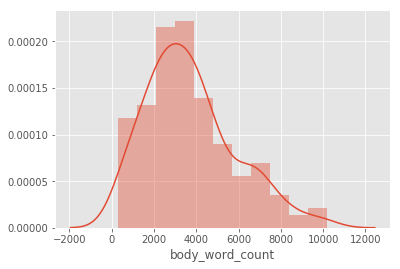

In [285]:
sns.distplot(df['body_word_count'])
df['body_word_count'].describe()

count     160.000000
mean     1167.231250
std       491.946809
min       191.000000
25%       847.750000
50%      1153.500000
75%      1463.000000
max      2782.000000
Name: body_unique_words, dtype: float64

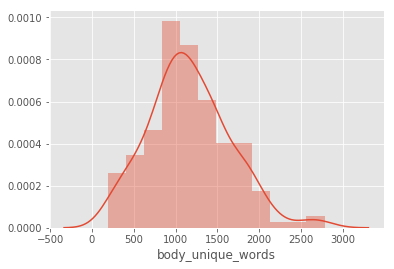

In [286]:
sns.distplot(df['body_unique_words'])
df['body_unique_words'].describe()

The papers are now ranging around 3000-4000 words with a unique word count average around 1000.

# Vectorization

Now that we have pre-processed the data, it is time to convert it into a format that can be handled by our algorithms. For this purpose we will be using tf-idf. This will convert our string formatted data into a measure of how important each word is to the instance out of the literature as a whole.

In [287]:
from sklearn.feature_extraction.text import TfidfVectorizer
def vectorize(text, maxx_features):
    
    vectorizer = TfidfVectorizer(max_features=maxx_features)
    X = vectorizer.fit_transform(text)
    return X

Vectorize our data. We will be clustering based off the content of the body text. The maximum number of features will be limited. Only the top 2 ** 12 features will be used, eseentially acting as a noise filter. Additionally, more features cause painfully long runtimes.

In [288]:
text = df['processed_text'].values
X = vectorize(text, 2 ** 12)
X.shape

(160, 4096)

# PCA  & Clustering

Let's see how much we can reduce the dimensions while still keeping 95% variance. We will apply Principle Component Analysis (PCA) to our vectorized data. The reason for this is that by keeping a large number of dimensions with PCA, you don’t destroy much of the information, but hopefully will remove some noise/outliers from the data, and make the clustering problem easier for k-means. Note that X_reduced will only be used for k-means, t-SNE will still use the original feature vector X that was generated through tf-idf on the NLP processed text.

(Thank you Dr. Edward Raff for the suggestion)

In [289]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.95, random_state=42)
X_reduced= pca.fit_transform(X.toarray())
X_reduced.shape

(160, 136)

To separate the literature, k-means will be run on the vectorized text. Given the number of clusters, k, k-means will categorize each vector by taking the mean distance to a randomly initialized centroid. The centroids are updated iteratively.

In [290]:
from sklearn.cluster import KMeans

### How many clusters? 

To find the best k value for k-means we'll look at the distortion at different k values. Distortion computes the sum of squared distances from each point to its assigned center. When distortion is plotted against k there will be a k value after which decreases in distortion are minimal. This is the desired number of clusters.

In [291]:
from sklearn import metrics
from scipy.spatial.distance import cdist

# run kmeans with many different k
distortions = []
K = range(2, 50)
for k in K:
    k_means = KMeans(n_clusters=k, random_state=42).fit(X_reduced)
    k_means.fit(X_reduced)
    distortions.append(sum(np.min(cdist(X_reduced, k_means.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])
    #print('Found distortion for {} clusters'.format(k))

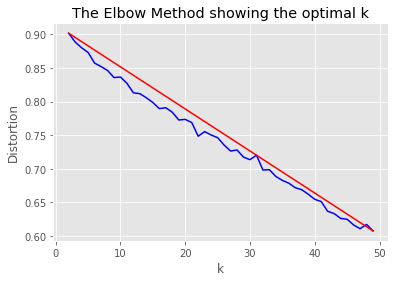

In [292]:
X_line = [K[0], K[-1]]
Y_line = [distortions[0], distortions[-1]]

# Plot the elbow
plt.plot(K, distortions, 'b-')
plt.plot(X_line, Y_line, 'r')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

No really distinct 'elbow' of the plot can be seen. k=9 is chosen.

In [345]:
NUM_CLUSTERS = 9

### Run k-means

Now that we have an appropriate k value, we can run k-means on the PCA-processed feature vector (X_reduced). 

In [346]:
k = NUM_CLUSTERS
kmeans = KMeans(n_clusters=k, random_state=42)
y_pred = kmeans.fit_predict(X_reduced)
df['y'] = y_pred

# Dimensionality Reduction with t-SNE

Using [t-SNE](https://lvdmaaten.github.io/tsne) we can reduce our high dimensional features vector to 2 dimensions. By using the 2 dimensions as x,y coordinates, the body_text can be plotted. 

> t-Distributed Stochastic Neighbor Embedding (t-SNE) reduces dimensionality while trying to keep similar instances close and dissimilar instances apart. It is mostly used for visualization, in particular to visualize clusters of instances in high-dimensional space[Hands-On Machine Learning with Scikit-Learn, Keras & TensorFlow: Second Edition | Aurélien Geron](https://github.com/ageron/handson-ml2)
> #### Cite: 

In [328]:
from sklearn.manifold import TSNE

tsne = TSNE(verbose=1, perplexity=100, random_state=42)
X_embedded = tsne.fit_transform(X.toarray())

[t-SNE] Computing 159 nearest neighbors...
[t-SNE] Indexed 160 samples in 0.001s...
[t-SNE] Computed neighbors for 160 samples in 0.005s...
[t-SNE] Computed conditional probabilities for sample 160 / 160
[t-SNE] Mean sigma: 0.432771
[t-SNE] KL divergence after 250 iterations with early exaggeration: 47.178600
[t-SNE] KL divergence after 800 iterations: 0.200363


So that step took a while! Let's take a look at what our data looks like when compressed to 2 dimensions. 

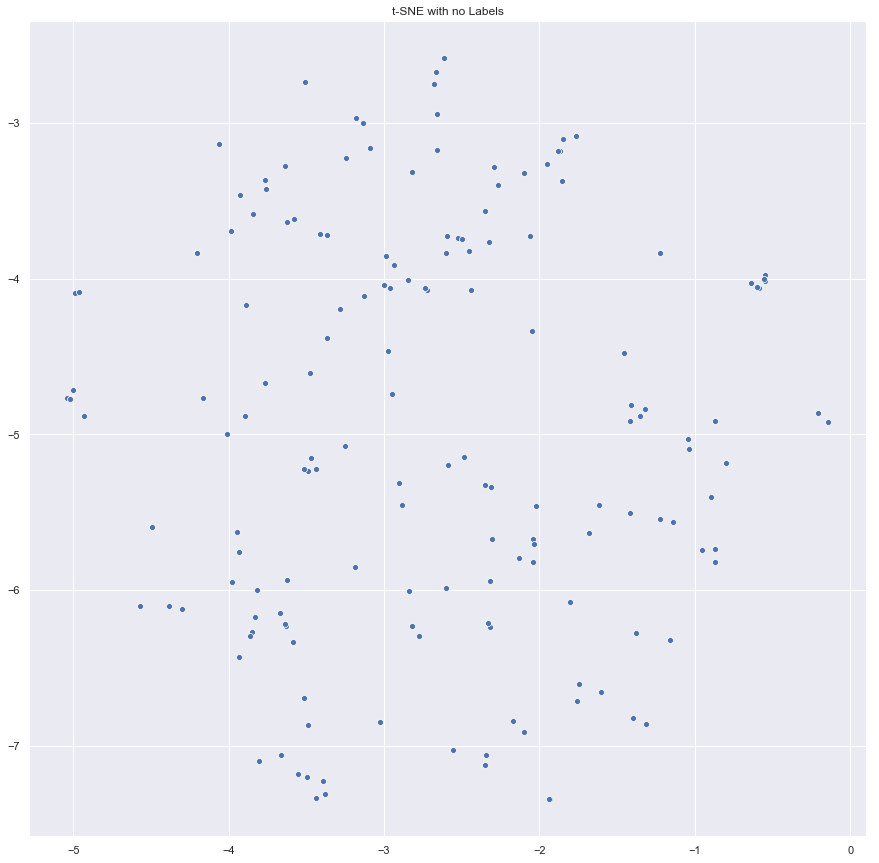

In [348]:
from matplotlib import pyplot as plt
import seaborn as sns

# sns settings
sns.set(rc={'figure.figsize':(15,15)})

# colors
palette = sns.color_palette("bright", 1)

# plot
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], palette=palette)
plt.title('t-SNE with no Labels')
plt.savefig("t-sne_covid19.png")
plt.show()

This looks pretty bland. There are some clusters we can immediately detect, but the many instances closer to the center are harder to separate. t-SNE did a good job at reducing the dimensionality, but now we need some labels. Let's use the clusters found by k-means as labels. This will help visually separate different concentrations of topics.

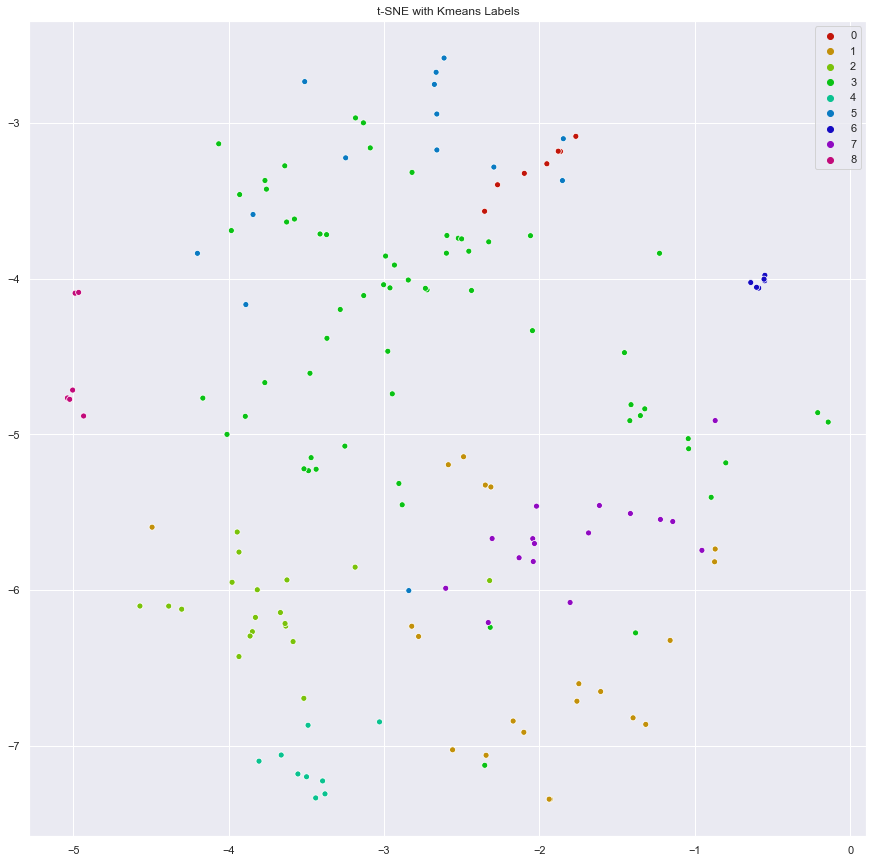

In [347]:
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns

# sns settings
sns.set(rc={'figure.figsize':(15,15)})

# colors
palette = sns.hls_palette(NUM_CLUSTERS, l=.4, s=.9)

# plot
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=y_pred, legend='full', palette=palette)
plt.title('t-SNE with Kmeans Labels')
plt.savefig("improved_cluster_tsne.png")
plt.show()

The labeled plot gives better insight into how the papers are grouped. It is interesting that both k-means and t-SNE are able to agree on certain clusters even though they were ran independetly. The location of each paper on the plot was determined by t-SNE while the label (color) was determined by k-means. If we look at a particular part of the plot where t-SNE has grouped many articles forming a cluster, it is likely that k-means is uniform in the labeling of this cluster (most of the cluster is the same color). This behavior shows that structure within the literature can be observed and measured to some extent. 

Now there are other cases where the colored labels (k-means) are spread out on the plot (t-SNE). This is a result of t-SNE and k-means finding different connections in the higher dimensional data. The topics of these papers often intersect so it hard to cleanly separate them. This effect can be observed in the formation of subclusters on the plot. These subclusters are a conglomeration of different k-means labels but may share some connection determined by t-SNE.

This organization of the data does not act as a simple search engine. The clustering + dimensionality reduction is performed on the mathematical similarities of the publications. As an unsupervised approach, the algorithms may even find connections that were unnaparent to humans. This may highlight hidden shared information and advance further research.


# Topic Modeling on Each Cluster

Now we will attempt to find the most significant words in each clusters. K-means clustered the articles but did not label the topics. Through topic modeling we will find out what the most important terms for each cluster are. This will add more meaning to the cluster by giving keywords to quickly identify the themes of the cluster.

For topic modeling, we will use LDA (Latent Dirichlet Allocation). In LDA, each document can be described by a distribution of topics and each topic can be described by a distribution of words[.](https://towardsdatascience.com/light-on-math-machine-learning-intuitive-guide-to-latent-dirichlet-allocation-437c81220158)

In [331]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

First we will create 21 vectorizers, one for each of our cluster labels

In [349]:
vectorizers = []
    
for ii in range(0, NUM_CLUSTERS):
    # Creating a vectorizer
    vectorizers.append(CountVectorizer(min_df=5, max_df=0.9, stop_words='english', lowercase=True, token_pattern='[a-zA-Z\-][a-zA-Z\-]{2,}'))

In [350]:
vectorizers[0]

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=0.9, max_features=None, min_df=5,
                ngram_range=(1, 1), preprocessor=None, stop_words='english',
                strip_accents=None, token_pattern='[a-zA-Z\\-][a-zA-Z\\-]{2,}',
                tokenizer=None, vocabulary=None)

Now we will vectorize the data from each of our clusters

In [351]:
vectorized_data = []

for current_cluster, cvec in enumerate(vectorizers):
    try:
        vectorized_data.append(cvec.fit_transform(df.loc[df['y'] == current_cluster, 'processed_text']))
    except Exception as e:
        print("Not enough instances in cluster: " + str(current_cluster))
        vectorized_data.append(None)

In [352]:
len(vectorized_data)

9

Topic modeling will be performed through the use of Latent Dirichlet Allocation (LDA). This is a generative statistical model that allows sets of words to be explained by a shared topic

In [353]:
# number of topics per cluster
NUM_TOPICS_PER_CLUSTER = 20

lda_models = []
for ii in range(0, NUM_CLUSTERS):
    # Latent Dirichlet Allocation Model
    lda = LatentDirichletAllocation(n_components=NUM_TOPICS_PER_CLUSTER, max_iter=10, learning_method='online',verbose=False, random_state=42)
    lda_models.append(lda)
    
lda_models[0]

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='online', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=20, n_jobs=None,
                          perp_tol=0.1, random_state=42, topic_word_prior=None,
                          total_samples=1000000.0, verbose=False)

For each cluster, we had created a correspoding LDA model in the previous step. We will now fit_transform all the LDA models on their respective cluster vectors

In [354]:
clusters_lda_data = []

for current_cluster, lda in enumerate(lda_models):
    # print("Current Cluster: " + str(current_cluster))
    
    if vectorized_data[current_cluster] != None:
        clusters_lda_data.append((lda.fit_transform(vectorized_data[current_cluster])))

Extracts the keywords from each cluster

In [355]:
# Functions for printing keywords for each topic
def selected_topics(model, vectorizer, top_n=3):
    current_words = []
    keywords = []
    
    for idx, topic in enumerate(model.components_):
        words = [(vectorizer.get_feature_names()[i], topic[i]) for i in topic.argsort()[:-top_n - 1:-1]]
        for word in words:
            if word[0] not in current_words:
                keywords.append(word)
                current_words.append(word[0])
                
    keywords.sort(key = lambda x: x[1])  
    keywords.reverse()
    return_values = []
    for ii in keywords:
        return_values.append(ii[0])
    return return_values

Append list of keywords for a single cluster to 2D list of length NUM_TOPICS_PER_CLUSTER

In [356]:
all_keywords = []
for current_vectorizer, lda in enumerate(lda_models):
    # print("Current Cluster: " + str(current_vectorizer))

    if vectorized_data[current_vectorizer] != None:
        all_keywords.append(selected_topics(lda, vectorizers[current_vectorizer]))

In [357]:
all_keywords[0][:10]

['individual',
 'node',
 'heterogeneity',
 'weight',
 'strategy',
 'outbreak',
 'use',
 'community',
 'infectious',
 'dynamic']

In [358]:
len(all_keywords)

9

### Save current outputs to file

Re-running some parts of the notebook (especially vectorization and t-SNE) are time intensive tasks. We want to make sure that the important outputs for generating the bokeh plot are saved for future use.

In [359]:
f=open('topics_studi.txt','w')

count = 0

for ii in all_keywords:

    if vectorized_data[count] != None:
        f.write(', '.join(ii) + "\n")
    else:
        f.write("Not enough instances to be determined. \n")
        f.write(', '.join(ii) + "\n")
    count += 1

f.close()

In [360]:
import pickle

# save the COVID-19 DataFrame, too large for github
pickle.dump(df, open("df_covid_studi.p", "wb" ))

# save the final t-SNE
pickle.dump(X_embedded, open("X_embedded_studi.p", "wb" ))

# save the labels generate with k-means(20)
pickle.dump(y_pred, open("y_pred_studi.p", "wb" ))

# Classify

Though arbitrary, after running kmeans, the data is now 'labeled'. This means that we now use supervised learning to see how well the clustering generalizes. This is just one way to evaluate the clustering. If k-means was able to find a meaningful split in the data, it should be possible to train a classifier to predict which cluster a given instance should belong to. 

In [361]:
# function to print out classification model report
def classification_report(model_name, test, pred):
    from sklearn.metrics import precision_score, recall_score
    from sklearn.metrics import accuracy_score
    from sklearn.metrics import f1_score
    
    print(model_name, ":\n")
    print("Accuracy Score: ", '{:,.3f}'.format(float(accuracy_score(test, pred)) * 100), "%")
    print("     Precision: ", '{:,.3f}'.format(float(precision_score(test, pred, average='macro')) * 100), "%")
    print("        Recall: ", '{:,.3f}'.format(float(recall_score(test, pred, average='macro')) * 100), "%")
    print("      F1 score: ", '{:,.3f}'.format(float(f1_score(test, pred, average='macro')) * 100), "%")

Let's split the data into train/test sets

In [362]:
from sklearn.model_selection import train_test_split

# test set size of 20% of the data and the random seed 42 <3
X_train, X_test, y_train, y_test = train_test_split(X.toarray(),y_pred, test_size=0.2, random_state=42)

print("X_train size:", len(X_train))
print("X_test size:", len(X_test), "\n")

X_train size: 128
X_test size: 32 



**Precision** is ratio of True Positives to True Positives + False Positives. This is the accuracy of positive predictions<br>
**Recall** (also known as TPR) measures the ratio of True Positives to True Positives + False Negatives. It measures the ratio of positive instances that are correctly detected by the classifer.<br>
**F1 score**  is the harmonic average of the precision and recall. F1 score will only be high if both precision and recall are high

#### Cite: [Hands-On Machine Learning with Scikit-Learn, Keras & TensorFlow: Second Edition | Aurélien Geron](https://github.com/ageron/handson-ml2) 

In [363]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import SGDClassifier

# SGD instance
sgd_clf = SGDClassifier(max_iter=10000, tol=1e-3, random_state=42, n_jobs=4)
# train SGD
sgd_clf.fit(X_train, y_train)

# cross validation predictions
sgd_pred = cross_val_predict(sgd_clf, X_train, y_train, cv=3, n_jobs=4)

# print out the classification report
classification_report("Stochastic Gradient Descent Report (Training Set)", y_train, sgd_pred)

Stochastic Gradient Descent Report (Training Set) :

Accuracy Score:  73.438 %
     Precision:  84.938 %
        Recall:  62.453 %
      F1 score:  68.013 %


To test for overfitting, let's see how the model generalizes over the test set

In [364]:
# cross validation predictions
sgd_pred = cross_val_predict(sgd_clf, X_test, y_test, cv=3, n_jobs=4)

# print out the classification report
classification_report("Stochastic Gradient Descent Report (Training Set)", y_test, sgd_pred)

D:\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)


Stochastic Gradient Descent Report (Training Set) :

Accuracy Score:  50.000 %
     Precision:  13.143 %
        Recall:  19.048 %
      F1 score:  15.385 %


D:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Now let's see how the model can generalize across the whole dataset.

In [365]:
sgd_cv_score = cross_val_score(sgd_clf, X.toarray(), y_pred, cv=10)
print("Mean cv Score - SGD: {:,.3f}".format(float(sgd_cv_score.mean()) * 100), "%")

D:\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 6 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


Mean cv Score - SGD: 81.043 %


# Plotting the data
The previous steps have given us clustering labels and a dataset of papers reduced to two dimensions. By pairing this with Bokeh, we can create an interactive plot of the literature. This should organize the papers such that related publications are in close proximity. To try to undertstand what the similarities may be, we have also performed topic modelling on each cluster of papers in order to pick out the key terms.

Bokeh will pair the actual papers with their positions on the t-SNE plot. Through this approach it will be easier to see how papers fit together, allowing for both exploration of the dataset and evaluation of the clustering. 

In [410]:
import os

# change into lib directory to load plot python scripts
main_path = os.getcwd()
os.chdir(lib_path)

In [411]:
# required libraries for plot
from call_backs import input_callback, selected_code  # file with customJS callbacks for bokeh
                                                      # github.com/MaksimEkin/COVID19-Literature-Clustering/blob/master/lib/call_backs.py
import bokeh
from bokeh.models import ColumnDataSource, HoverTool, LinearColorMapper, CustomJS, Slider, TapTool, TextInput
from bokeh.palettes import Category20
from bokeh.transform import linear_cmap, transform
from bokeh.io import output_file, show, output_notebook
from bokeh.plotting import figure
from bokeh.models import RadioButtonGroup, TextInput, Div, Paragraph
from bokeh.layouts import column, widgetbox, row, layout
from bokeh.layouts import column

In [412]:
# go back
os.chdir(main_path)

## Load the Keywords per Cluster

In [369]:
import os

topic_path = 'topics.txt'
with open(topic_path) as f:
    topics = f.readlines()

## Setup

In [371]:
# show on notebook
output_notebook()
# target labels
y_labels = y_pred

# data sources
source = ColumnDataSource(data=dict(
    x= X_embedded[:,0], 
    y= X_embedded[:,1],
    x_backup = X_embedded[:,0],
    y_backup = X_embedded[:,1],
    desc= y_labels, 
    titles= df['title'],
    authors = df['authors'],
    journal = df['journal'],
    abstract = df['abstract_summary'],
    labels = ["C-" + str(x) for x in y_labels],
    links = df['doi']
    ))

# hover over information
hover = HoverTool(tooltips=[
    ("Title", "@titles{safe}"),
    ("Author(s)", "@authors{safe}"),
    ("Journal", "@journal"),
    ("Abstract", "@abstract{safe}"),
    ("Link", "@links")
],
point_policy="follow_mouse")

# map colors
mapper = linear_cmap(field_name='desc', 
                     palette=Category20[20],
                     low=min(y_labels) ,high=max(y_labels))

# prepare the figure
plot = figure(plot_width=1200, plot_height=850, 
           tools=[hover, 'pan', 'wheel_zoom', 'box_zoom', 'reset', 'save', 'tap'], 
           title="Clustering of the COVID-19 Literature with t-SNE and K-Means", 
           toolbar_location="above")

# plot settings
plot.scatter('x', 'y', size=5, 
          source=source,
          fill_color=mapper,
          line_alpha=0.3,
          line_color="black",
          legend = 'labels')
plot.legend.background_fill_alpha = 0.6

Loading BokehJS ...

## Widgets

In [372]:
# Keywords
text_banner = Paragraph(text= 'Keywords: Slide to specific cluster to see the keywords.', height=45)
input_callback_1 = input_callback(plot, source, text_banner, topics)

# currently selected article
div_curr = Div(text="""Click on a plot to see the link to the article.""",height=150)
callback_selected = CustomJS(args=dict(source=source, current_selection=div_curr), code=selected_code())
taptool = plot.select(type=TapTool)
taptool.callback = callback_selected

# WIDGETS
slider = Slider(start=0, end=20, value=20, step=1, title="Cluster #", callback=input_callback_1)
keyword = TextInput(title="Search:", callback=input_callback_1)

# pass call back arguments
input_callback_1.args["text"] = keyword
input_callback_1.args["slider"] = slider

## Style

In [373]:
# STYLE
slider.sizing_mode = "stretch_width"
slider.margin=15

keyword.sizing_mode = "scale_both"
keyword.margin=15

div_curr.style={'color': '#BF0A30', 'font-family': 'Helvetica Neue, Helvetica, Arial, sans-serif;', 'font-size': '1.1em'}
div_curr.sizing_mode = "scale_both"
div_curr.margin = 20

text_banner.style={'color': '#0269A4', 'font-family': 'Helvetica Neue, Helvetica, Arial, sans-serif;', 'font-size': '1.1em'}
text_banner.sizing_mode = "scale_both"
text_banner.margin = 20

plot.sizing_mode = "scale_both"
plot.margin = 5

r = row(div_curr,text_banner)
r.sizing_mode = "stretch_width"

## SHOW

In [374]:
# LAYOUT OF THE PAGE
l = layout([
    [slider, keyword],
    [text_banner],
    [div_curr],
    [plot],
])
l.sizing_mode = "scale_both"

# show
output_file('t-sne_covid-19_interactive.html')
show(l)

# Analyse the clusters

In [387]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [389]:
stopwords = list(STOPWORDS)
custom_stop_words = [
    'doi', 'preprint', 'copyright', 'peer', 'reviewed', 'org', 'https', 'et', 'al', 'author', 'figure', 
    'rights', 'reserved', 'permission', 'used', 'using', 'biorxiv', 'medrxiv', 'license', 'fig', 'fig.', 
    'al.', 'Elsevier', 'PMC', 'CZI', 'www'
]

for w in custom_stop_words:
    if w not in stopwords:
        stopwords.append(w)
stopwords = set(stopwords)

### Cluster 0

195756 words in total.
7 articles in this cluster.


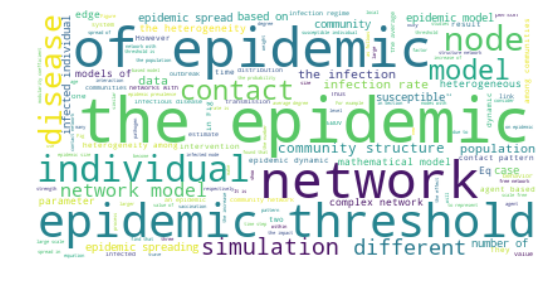

In [400]:
cluster_number=0
text = " ".join(paper for paper in df[np.where(y_pred==cluster_number, True, False)]['body_text'])
print ("{} words in total.".format(len(text)))
print("{} articles in this cluster.".format(len(df[np.where(y_pred==cluster_number, True, False)])))
# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)

# Display the generated image:
# the matplotlib way:
plt.figure(figsize=(9, 12))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Seems like Cluster 0 is mainly about infection networks.

### Cluster 1

530721 words in total.
21 articles in this cluster.


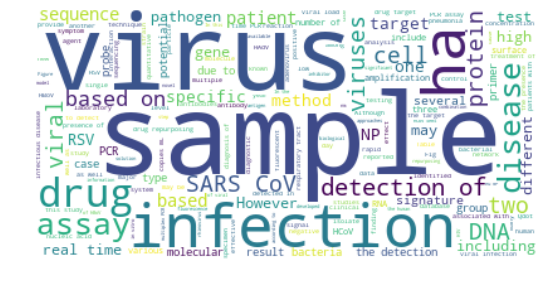

In [399]:
cluster_number=1
text = " ".join(paper for paper in df[np.where(y_pred==cluster_number, True, False)]['body_text'])
print ("{} words in total.".format(len(text)))
print("{} articles in this cluster.".format(len(df[np.where(y_pred==cluster_number, True, False)])))
# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)

# Display the generated image:
# the matplotlib way:
plt.figure(figsize=(9, 12))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Seems like Cluster 1 is mainly about the virus makup and drug design.

### Cluster 2

204703 words in total.
19 articles in this cluster.


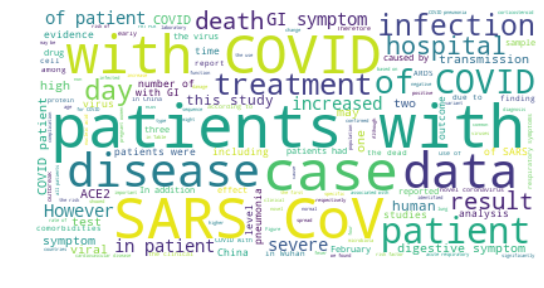

In [398]:
cluster_number=2
text = " ".join(paper for paper in df[np.where(y_pred==cluster_number, True, False)]['body_text'])
print ("{} words in total.".format(len(text)))
print("{} articles in this cluster.".format(len(df[np.where(y_pred==cluster_number, True, False)])))
# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)

# Display the generated image:
# the matplotlib way:
plt.figure(figsize=(9, 12))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Seems like Cluster 2 is mainly about patient data.

### Cluster 3

1715240 words in total.
62 articles in this cluster.


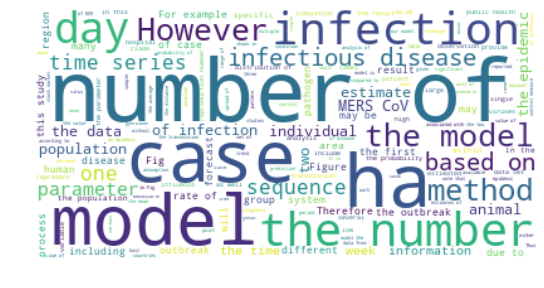

In [397]:
cluster_number=3
text = " ".join(paper for paper in df[np.where(y_pred==cluster_number, True, False)]['body_text'])
print ("{} words in total.".format(len(text)))
print("{} articles in this cluster.".format(len(df[np.where(y_pred==cluster_number, True, False)])))
# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)

# Display the generated image:
# the matplotlib way:
plt.figure(figsize=(9, 12))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Seems like Cluster 3 is mainly about modelling the number of infection cases.

### Cluster 4

148626 words in total.
9 articles in this cluster.


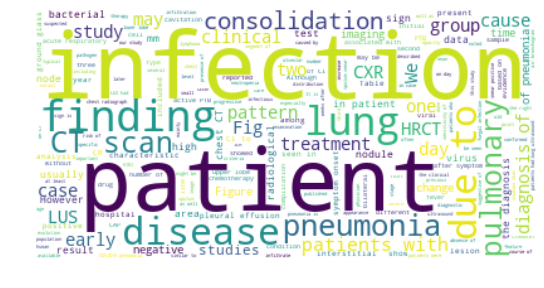

In [401]:
cluster_number=4
text = " ".join(paper for paper in df[np.where(y_pred==cluster_number, True, False)]['body_text'])
print ("{} words in total.".format(len(text)))
print("{} articles in this cluster.".format(len(df[np.where(y_pred==cluster_number, True, False)])))
# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)

# Display the generated image:
# the matplotlib way:
plt.figure(figsize=(9, 12))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Seems like Cluster 4 is mainly about finding infections and respiratory diseases in patients.

### Cluster 5

419238 words in total.
14 articles in this cluster.


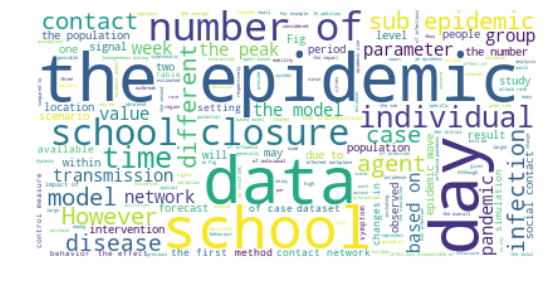

In [402]:
cluster_number=5
text = " ".join(paper for paper in df[np.where(y_pred==cluster_number, True, False)]['body_text'])
print ("{} words in total.".format(len(text)))
print("{} articles in this cluster.".format(len(df[np.where(y_pred==cluster_number, True, False)])))
# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)

# Display the generated image:
# the matplotlib way:
plt.figure(figsize=(9, 12))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Seems like Cluster 5 is mainly about modelling the school opening times.

### Cluster 6

137201 words in total.
6 articles in this cluster.


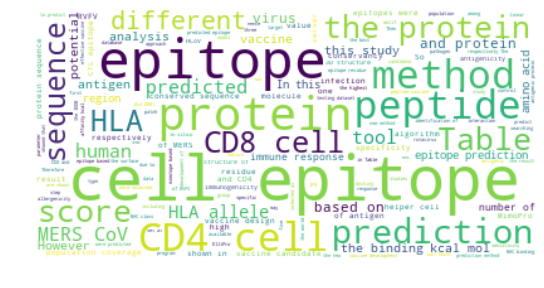

In [403]:
cluster_number=6
text = " ".join(paper for paper in df[np.where(y_pred==cluster_number, True, False)]['body_text'])
print ("{} words in total.".format(len(text)))
print("{} articles in this cluster.".format(len(df[np.where(y_pred==cluster_number, True, False)])))
# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)

# Display the generated image:
# the matplotlib way:
plt.figure(figsize=(9, 12))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Seems like Cluster 6 is mainly about protein interactions.

### Cluster 7

299154 words in total.
16 articles in this cluster.


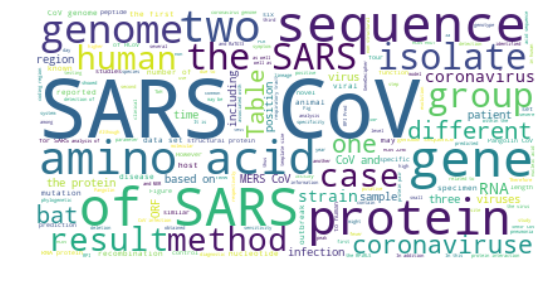

In [404]:
cluster_number=7
text = " ".join(paper for paper in df[np.where(y_pred==cluster_number, True, False)]['body_text'])
print ("{} words in total.".format(len(text)))
print("{} articles in this cluster.".format(len(df[np.where(y_pred==cluster_number, True, False)])))
# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)

# Display the generated image:
# the matplotlib way:
plt.figure(figsize=(9, 12))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Seems like Cluster 7 is mainly about SARS and CoV genome analysis.

### Cluster 8

138627 words in total.
6 articles in this cluster.


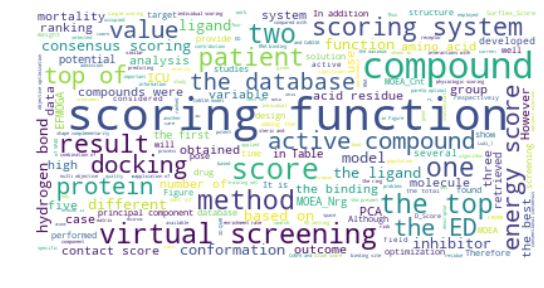

In [405]:
cluster_number=8
text = " ".join(paper for paper in df[np.where(y_pred==cluster_number, True, False)]['body_text'])
print ("{} words in total.".format(len(text)))
print("{} articles in this cluster.".format(len(df[np.where(y_pred==cluster_number, True, False)])))
# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)

# Display the generated image:
# the matplotlib way:
plt.figure(figsize=(9, 12))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Seems like Cluster 8 is more of a mixed set maybe about scoring patient data for risk/mortality.

# Citation/Sources

Kaggle Submission: [COVID-19 Literature Clustering | Kaggle](https://www.kaggle.com/maksimeren/covid-19-literature-clustering#Unsupervised-Learning:-Clustering-with-K-Means)
 
 ```
@inproceedings{Raff2020,
	author = {Raff, Edward and Nicholas, Charles and McLean, Mark},
	booktitle = {The Thirty-Fourth AAAI Conference on Artificial Intelligence},
	title = {{A New Burrows Wheeler Transform Markov Distance}},
	url = {http://arxiv.org/abs/1912.13046},
	year = {2020},
}
```
```
@misc{Kaggle,
	author = {Kaggle},
	title = {COVID-19 Open Research Dataset Challenge (CORD-19)},
	year = {2020},
	month = {March},
	note = {Allen Institute for AI in partnership with the Chan Zuckerberg Initiative, Georgetown University’s Center for   Security and Emerging Technology, Microsoft Research, and the National Library of Medicine - National Institutes of Health, in coordination with The White House Office of Science and Technology Policy.},
	howpublished = {\url{https://www.kaggle.com/allen-institute-for-ai/CORD-19-research-challenge}}
}
```
```
@inproceedings{Shakespeare,
	author = {Nicholas, Charles},
	title = {Mr. Shakespeare, Meet Mr. Tucker},
	booktitle = {High Performance Computing and Data Analytics Workshop},
	year = {2019},
	month = {September},
	location = { Linthicum Heights, MD, USA},
}
```
```
@inproceedings{raff_lzjd_2017,
	author = {Raff, Edward and Nicholas, Charles},
	title = {An Alternative to NCD for Large Sequences, Lempel-Ziv Jaccard Distance},
	booktitle = {Proceedings of the 23rd ACM SIGKDD International Conference on Knowledge Discovery and Data Mining},
	series = {KDD '17},
	year = {2017},
	isbn = {978-1-4503-4887-4},
	location = {Halifax, NS, Canada},
	pages = {1007--1015},
	numpages = {9},
	url = {http://doi.acm.org/10.1145/3097983.3098111},
	doi = {10.1145/3097983.3098111},
	acmid = {3098111},
	publisher = {ACM},
	address = {New York, NY, USA},
	keywords = {cyber security, jaccard similarity, lempel-ziv, malware classification, normalized compression distance},
}
```
```
@inproceedings{ML_Book,
    author = {Aurélien Geron},
    title = {Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow},
    pages = {91, 233},
    series = {2},
    year = {2019},
    isbn = {978-1-492-03264-9},
    publisher = {O'Reilly},
    copyright = {Kiwisoft S.A.S},
}
```

<br>
<br>

**Thank you for looking at our notebook. We greatly appreciate tips, suggestions, and upvotes :)** <br>
**If you would like to check out the interactive plot with the full dataset, please visit:**

https://maksimekin.github.io/COVID19-Literature-Clustering/plots/t-sne_covid-19_interactive.html